# Strat:

## Class: COMP 4432
### Project: Assignment 3
#### Author: Michael Ghattas

In [127]:
# Load Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay

#### Part One:

In [128]:
# Load Titanic DataFrame
df = sns.load_dataset('titanic')
df.head(10)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False


In [129]:
# Null value count and percentage
null_summary = df.isnull().sum().to_frame('count')
null_summary['percent'] = 100 * null_summary['count'] / len(df)
display(null_summary)

,count,percent
survived,0,0.000000
pclass,0,0.000000
sex,0,0.000000
age,177,19.865320
sibsp,0,0.000000
parch,0,0.000000
fare,0,0.000000
embarked,2,0.224467
class,0,0.000000
who,0,0.000000


#### `deck` has more than `77%` `NULL` values.

In [130]:

# Remove feature with >75% nulls
df = df.drop(columns=['deck'])

# Define candidate redundant feature pairs
redundant_pairs = [
    ('alive', 'survived'),
    ('class', 'pclass'),
    ('embarked', 'embark_town'),
    ('adult_male', 'who')
]

# Store results in a dictionary
redundancy_results = {}

# Check direct equality and unique pairings
for col1, col2 in redundant_pairs:
    print(f"\nAnalyzing Redundancy: '{col1}' and '{col2}'")

    # Value counts of element-wise equality
    eq_counts = (df[col1] == df[col2]).value_counts(dropna=False)
    print(f"\nEquality counts:\n{eq_counts}")

    # Unique pairings (i.e., mapping of one to another)
    unique_pairs = df[[col1, col2]].drop_duplicates()
    print(f"\nUnique pairs (drop_duplicates):\n{unique_pairs}")

    # Groupby distributions
    print(f"\nGroupby '{col1}' -> '{col2}' distribution:")
    print(df.groupby(col1)[col2].value_counts(normalize=True).unstack())

    redundancy_results[f"{col1}_{col2}"] = {
        'equality_counts': eq_counts,
        'unique_pairs': unique_pairs
    }



Analyzing Redundancy: 'alive' and 'survived'

Equality counts:
False    891
Name: count, dtype: int64

Unique pairs (drop_duplicates):
  alive  survived
0    no         0
1   yes         1

Groupby 'alive' -> 'survived' distribution:
survived    0    1
alive             
no        1.0  NaN
yes       NaN  1.0

Analyzing Redundancy: 'class' and 'pclass'

Equality counts:
False    891
Name: count, dtype: int64

Unique pairs (drop_duplicates):
    class  pclass
0   Third       3
1   First       1
9  Second       2

Groupby 'class' -> 'pclass' distribution:
pclass    1    2    3
class                
First   1.0  0.0  0.0
Second  0.0  1.0  0.0
Third   0.0  0.0  1.0

Analyzing Redundancy: 'embarked' and 'embark_town'

Equality counts:
False    891
Name: count, dtype: int64

Unique pairs (drop_duplicates):
   embarked  embark_town
0         S  Southampton
1         C    Cherbourg
5         Q   Queenstown
61      NaN          NaN

Groupby 'embarked' -> 'embark_town' distribution:
embark_town 

/var/folders/59/x0yvg0z14jd2bd_xw683tqrh0000gn/T/ipykernel_17017/1562710908.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(col1)[col2].value_counts(normalize=True).unstack())


#### 1. `alive` and `survived`
- `alive` is a string label (`'yes'` or `'no'`), while `survived` is a numeric binary (1 or 0).
- **All rows** where `alive == 'yes'` have `survived == 1`, and `alive == 'no'` matches `survived == 0`.
- Grouping confirms this is a **perfect mapping**:
  - `'yes'` -> 1
  - `'no'` -> 0

**Conclusion:** Redundant. Keep `survived` for modeling, drop `alive`.

---

#### 2. `class` and `pclass`
- `class` is categorical (`'First'`, `'Second'`, `'Third'`), while `pclass` is numeric (1, 2, 3).
- Drop duplicates show a **1-to-1 mapping**:
  - `'First'` -> 1, `'Second'` -> 2, `'Third'` -> 3
- Grouping confirms this mapping is **deterministic**.

**Conclusion:** Redundant. Keep `pclass` for numeric modeling, drop `class`.

---

#### 3. `embarked` and `embark_town`
- `embarked` is a single-letter code (`'C'`, `'Q'`, `'S'`), while `embark_town` is a string name.
- Drop duplicates and grouping show:
  - `'C'` -> `'Cherbourg'`, `'Q'` -> `'Queenstown'`, `'S'` -> `'Southampton'`
- Missing values align across both.

**Conclusion:** Redundant. Keep `embarked` for compact representation, drop `embark_town`.

---

#### 4. `adult_male` and `who`
- `who` is categorical (`'man'`, `'woman'`, `'child'`), while `adult_male` is Boolean.
- All rows where `who == 'man'` have `adult_male == True`; all others (`'woman'`, `'child'`) have `False`.
- Grouping confirms:
  - `adult_male = True` -> only `who == 'man'`
  - `adult_male = False` -> `who == 'woman'` or `'child'`

**Conclusion:** Redundant. Keep `adult_male` for binary modeling, drop `who`.

In [131]:
# Drop redundant features
df = df.drop(columns=['alive', 'class', 'embarked', 'who'])
display(df)

,survived,pclass,sex,age,sibsp,parch,fare,adult_male,embark_town,alone
0,0,3,male,22.0,1,0,7.2500,True,Southampton,False
1,1,1,female,38.0,1,0,71.2833,False,Cherbourg,False
2,1,3,female,26.0,0,0,7.9250,False,Southampton,True
3,1,1,female,35.0,1,0,53.1000,False,Southampton,False
4,0,3,male,35.0,0,0,8.0500,True,Southampton,True
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,True,Southampton,True
887,1,1,female,19.0,0,0,30.0000,False,Southampton,True
888,0,3,female,NaN,1,2,23.4500,False,Southampton,False
889,1,1,male,26.0,0,0,30.0000,True,Cherbourg,True


In [132]:
# adult_male engineering
df.groupby('adult_male')[['age']].describe()
df.groupby('adult_male')['sex'].value_counts(normalize=True)

thresholds = range(12, 25)
best_match = 0
best_threshold = None

for t in thresholds:
    logic = (df['sex'] == 'male') & (df['age'] >= t)
    match = (logic == df['adult_male']).mean()
    print(f"Threshold {t}: match rate = {match:.4f}")
    if match > best_match:
        best_match = match
        best_threshold = t

print(f"\nBest threshold: {best_threshold}, Match rate: {best_match:.4f}")

Threshold 12: match rate = 0.8563
Threshold 13: match rate = 0.8575
Threshold 14: match rate = 0.8575
Threshold 15: match rate = 0.8597
Threshold 16: match rate = 0.8608
Threshold 17: match rate = 0.8485
Threshold 18: match rate = 0.8406
Threshold 19: match rate = 0.8260
Threshold 20: match rate = 0.8058
Threshold 21: match rate = 0.7901
Threshold 22: match rate = 0.7710
Threshold 23: match rate = 0.7542
Threshold 24: match rate = 0.7419

Best threshold: 16, Match rate: 0.8608


#### `adult_male` is engineered from features age and sex, such that: if `age >= 16` and `sex == 'male'`, then `adult_male` is `True`, else `False`.

In [133]:
# Drop adult_male
df = df.drop(columns=['adult_male'])
display(df)

,survived,pclass,sex,age,sibsp,parch,fare,embark_town,alone
0,0,3,male,22.0,1,0,7.2500,Southampton,False
1,1,1,female,38.0,1,0,71.2833,Cherbourg,False
2,1,3,female,26.0,0,0,7.9250,Southampton,True
3,1,1,female,35.0,1,0,53.1000,Southampton,False
4,0,3,male,35.0,0,0,8.0500,Southampton,True
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,Southampton,True
887,1,1,female,19.0,0,0,30.0000,Southampton,True
888,0,3,female,NaN,1,2,23.4500,Southampton,False
889,1,1,male,26.0,0,0,30.0000,Cherbourg,True


In [134]:
# Total passengers by sex
total_by_sex = df['sex'].value_counts()

# Count who died
deaths_by_sex = df[df['survived'] == 0]['sex'].value_counts()

# Count who survived
survivors_by_sex = df[df['survived'] == 1]['sex'].value_counts()

# Percentage of males who died
percent_male_died = (deaths_by_sex['male'] / total_by_sex['male']) * 100

# Percentage of females who died
percent_female_died = (deaths_by_sex['female'] / total_by_sex['female']) * 100

# Percentage of females who did NOT survive
percent_female_not_survived = percent_female_died

print(f"Death counts by sex:\n{deaths_by_sex}\n")
print(f"Total passengers by sex:\n{total_by_sex}\n")

print(f"Percentage of male passengers who died: {percent_male_died:.2f}%")
print(f"Percentage of female passengers who did not survive: {percent_female_not_survived:.2f}%")

Death counts by sex:
sex
male      468
female     81
Name: count, dtype: int64

Total passengers by sex:
sex
male      577
female    314
Name: count, dtype: int64

Percentage of male passengers who died: 81.11%
Percentage of female passengers who did not survive: 25.80%


In [135]:
# Percentage survived by pclass
survival_by_class = df.groupby('pclass')['survived'].mean() * 100
print("Survival percentage by class:\n", survival_by_class)

Survival percentage by class:
 pclass
1    62.962963
2    47.282609
3    24.236253
Name: survived, dtype: float64


Fare distribution summary:
 count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: fare, dtype: float64


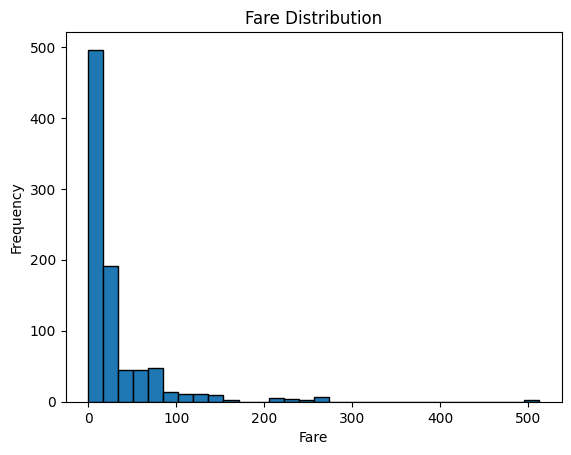

In [136]:
# Describe the distribution of fare values
fare_description = df['fare'].describe()
print("Fare distribution summary:\n", fare_description)

# Histogram
df['fare'].plot.hist(bins=30, edgecolor='black')
plt.title("Fare Distribution")
plt.xlabel("Fare")
plt.ylabel("Frequency")
plt.show()

#### The `fare` variable is right-skewed, with most passengers paying lower fares and a few paying very high amounts.

Non-null age distribution summary:
 count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: age, dtype: float64


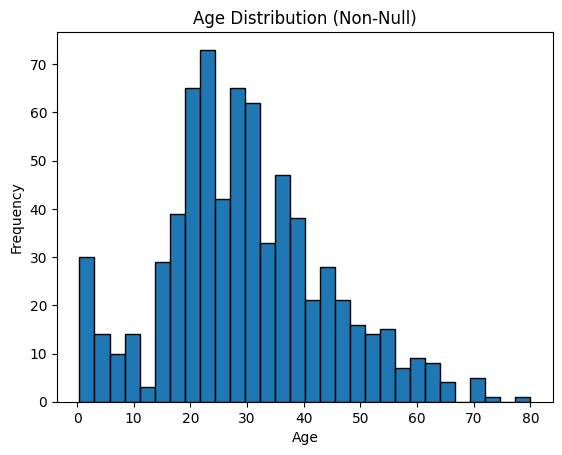

In [137]:
# Describe the distribution of non-null age values
age_description = df['age'].dropna().describe()
print("Non-null age distribution summary:\n", age_description)

# Histogram
df['age'].dropna().plot.hist(bins=30, edgecolor='black')
plt.title("Age Distribution (Non-Null)")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

#### The `age` distribution appears approximately normal but slightly skewed right, with a concentration of passengers between `15` and `45`.


In [138]:
# What is the median age for each passenger class?
median_age_by_class = df.groupby('pclass')['age'].median()
print("Median age by class:\n", median_age_by_class)

Median age by class:
 pclass
1    37.0
2    29.0
3    24.0
Name: age, dtype: float64


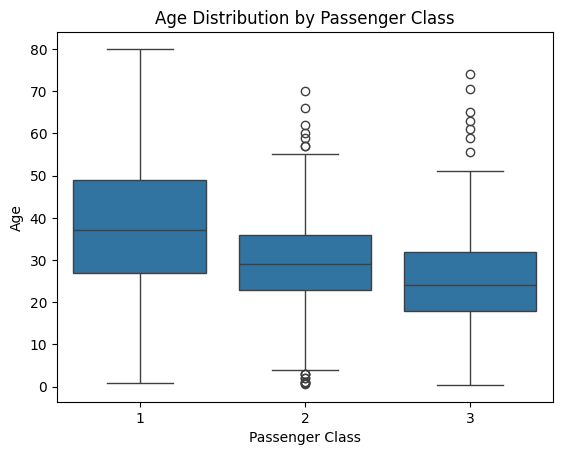

In [139]:
# Plot the distributions of age by passenger class in box plots
sns.boxplot(x='pclass', y='age', data=df)
plt.title('Age Distribution by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Age')
plt.show()

In [140]:
# Drop rows with missing values in 'embark_town'
df = df.dropna(subset=['embark_town'])
print("Rows remaining after dropping missing 'embark_town':", len(df))

Rows remaining after dropping missing 'embark_town': 889


In [141]:
# Partition the data into Train and Test sets (stratified)

# Separate features and target
X = df.drop(columns=['survived'])  # input features
y = df['survived']                 # target variable

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [142]:
# Show that the target rate was maintained in all splits

# Function to compute target rate
def compute_target_rate(label, name):
    rate = label.mean() * 100
    print(f"Target rate in {name}: {rate:.2f}%")

compute_target_rate(y, 'Full Dataset')
compute_target_rate(y_train, 'Training Set')
compute_target_rate(y_test, 'Testing Set')

Target rate in Full Dataset: 38.25%
Target rate in Training Set: 38.26%
Target rate in Testing Set: 38.20%


In [143]:
# Stratified imputation for missing age using median by pclass

# Compute median age by pclass from training data only
median_age_by_class = X_train.groupby('pclass')['age'].median()

# Function to fill age using group-specific median
def stratified_impute(df, median_lookup):
    return df.apply(
        lambda row: median_lookup[row['pclass']] if pd.isnull(row['age']) else row['age'],
        axis=1
    )

# Apply to training and testing sets
X_train['age'] = stratified_impute(X_train, median_age_by_class)
X_test['age'] = stratified_impute(X_test, median_age_by_class)

In [144]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 711 entries, 621 to 507
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pclass       711 non-null    int64  
 1   sex          711 non-null    object 
 2   age          711 non-null    float64
 3   sibsp        711 non-null    int64  
 4   parch        711 non-null    int64  
 5   fare         711 non-null    float64
 6   embark_town  711 non-null    object 
 7   alone        711 non-null    bool   
dtypes: bool(1), float64(2), int64(3), object(2)
memory usage: 45.1+ KB


#### Features with `object` types are of `Pandas` data type `category`.

In [145]:
# Identify features that should be treated as categorical

# View data types and cardinality to identify candidates
for col in X_train.columns:
    print(f"{col}: {X_train[col].nunique()} unique values")

pclass: 3 unique values
sex: 2 unique values
age: 83 unique values
sibsp: 7 unique values
parch: 7 unique values
fare: 219 unique values
embark_town: 3 unique values
alone: 2 unique values


#### The following input features should be treated as categorical:
1. **sex** — Gender of the passenger; values: `male`, `female`  
2. **embark_town** — Port of embarkation; values: `Cherbourg`, `Queenstown`, `Southampton`  
3. **alone** — Whether the passenger was alone; boolean-like: `True`/`False` 
4. **pclass** — Passenger class (`1`, `2`, `3`); though numeric, it represents ordered categories


In [146]:
# Encode categorical features using OneHotEncoder

# Select categorical columns
categorical_cols = ['sex', 'embark_town', 'alone', 'pclass']

# Initialize encoder
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit and transform training data
X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
X_test_encoded = encoder.transform(X_test[categorical_cols])

# Convert to DataFrames
encoded_train_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=X_train.index)
encoded_test_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=X_test.index)

# Drop original categorical columns and concat encoded ones
X_train = pd.concat([X_train.drop(columns=categorical_cols), encoded_train_df], axis=1)
X_test = pd.concat([X_test.drop(columns=categorical_cols), encoded_test_df], axis=1)

# Confirm update
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 711 entries, 621 to 507
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      711 non-null    float64
 1   sibsp                    711 non-null    int64  
 2   parch                    711 non-null    int64  
 3   fare                     711 non-null    float64
 4   sex_male                 711 non-null    float64
 5   embark_town_Queenstown   711 non-null    float64
 6   embark_town_Southampton  711 non-null    float64
 7   alone_True               711 non-null    float64
 8   pclass_2                 711 non-null    float64
 9   pclass_3                 711 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 61.1 KB
None


#### Part Two:

In [147]:
# Initialize models
log_clf = LogisticRegression(max_iter=1000)
svc_clf = SVC(probability=True)
dt_clf = DecisionTreeClassifier()

# Cross-validated predicted probabilities
log_proba = cross_val_predict(log_clf, X_train, y_train, cv=5, method='predict_proba')
svc_proba = cross_val_predict(svc_clf, X_train, y_train, cv=5, method='predict_proba')
dt_proba = cross_val_predict(dt_clf, X_train, y_train, cv=5, method='predict_proba')

# Get class predictions from probabilities
log_preds = np.argmax(log_proba, axis=1)
svc_preds = np.argmax(svc_proba, axis=1)
dt_preds = np.argmax(dt_proba, axis=1)

# Evaluation
print("Logistic Regression")
print(classification_report(y_train, log_preds))
print(confusion_matrix(y_train, log_preds))
print("ROC AUC:", roc_auc_score(y_train, log_proba[:,1]))

print("\nSupport Vector Classifier")
print(classification_report(y_train, svc_preds))
print(confusion_matrix(y_train, svc_preds))
print("ROC AUC:", roc_auc_score(y_train, svc_proba[:,1]))

print("\nDecision Tree Classifier")
print(classification_report(y_train, dt_preds))
print(confusion_matrix(y_train, dt_preds))
print("ROC AUC:", roc_auc_score(y_train, dt_proba[:,1]))

Logistic Regression
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       439
           1       0.75      0.70      0.73       272

    accuracy                           0.80       711
   macro avg       0.79      0.78      0.78       711
weighted avg       0.80      0.80      0.80       711

[[377  62]
 [ 82 190]]
ROC AUC: 0.8455547367010586

Support Vector Classifier
              precision    recall  f1-score   support

           0       0.69      0.92      0.79       439
           1       0.72      0.32      0.44       272

    accuracy                           0.69       711
   macro avg       0.70      0.62      0.61       711
weighted avg       0.70      0.69      0.66       711

[[405  34]
 [185  87]]
ROC AUC: 0.7201988141498057

Decision Tree Classifier
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       439
           1       0.70      0.72      0.71       272

    acc

#### Part Three:

In [148]:
# Standardize the training and testing sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Recalculate cross-val predictions with SVC using scaled data
svc_proba_scaled = cross_val_predict(svc_clf, X_train_scaled, y_train, cv=5, method='predict_proba')
svc_preds_scaled = np.argmax(svc_proba_scaled, axis=1)

print("Scaled Support Vector Classifier")
print(classification_report(y_train, svc_preds_scaled))
print(confusion_matrix(y_train, svc_preds_scaled))
print("ROC AUC:", roc_auc_score(y_train, svc_proba_scaled[:,1]))

Scaled Support Vector Classifier
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       439
           1       0.84      0.64      0.73       272

    accuracy                           0.82       711
   macro avg       0.82      0.78      0.80       711
weighted avg       0.82      0.82      0.81       711

[[406  33]
 [ 97 175]]
ROC AUC: 0.8387084617446066


#### Comparison Between Unscaled and Scaled SVC Performance

- **Unscaled SVC ROC AUC:** `~0.7167`
- **Scaled SVC ROC AUC:** `0.8376`

In [149]:
# GridSearchCV for best SVC parameters
param_grid = {
    'kernel': ['rbf'],
    'gamma': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5],
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
}

svc = SVC(probability=True)
grid_search = GridSearchCV(svc, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train_scaled, y_train)

# Best params and score
print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC Score:", grid_search.best_score_)

Best Parameters: {'C': 0.5, 'gamma': 0.005, 'kernel': 'rbf'}
Best ROC AUC Score: 0.8525623265043327


Final Evaluation on Test Set
              precision    recall  f1-score   support

           0       0.79      0.86      0.83       110
           1       0.74      0.63      0.68        68

    accuracy                           0.78       178
   macro avg       0.77      0.75      0.75       178
weighted avg       0.77      0.78      0.77       178

[[95 15]
 [25 43]]
Test ROC AUC: 0.8447860962566845


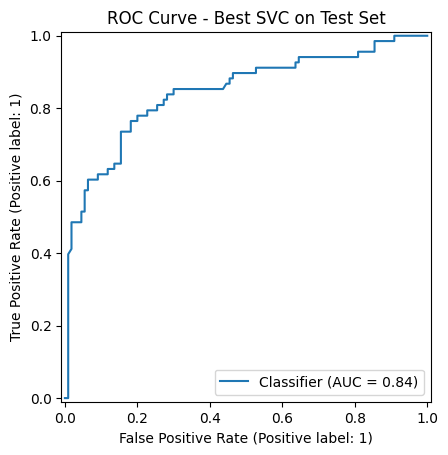

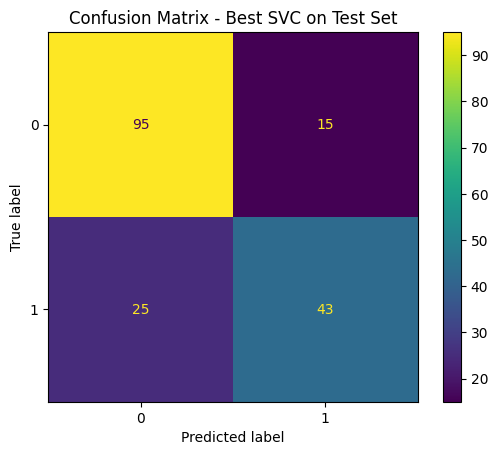

In [150]:
# Evaluate best estimator on test set
y_pred_test = grid_search.best_estimator_.predict(X_test_scaled)
y_proba_test = grid_search.best_estimator_.predict_proba(X_test_scaled)[:, 1]

print("Final Evaluation on Test Set")
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
print("Test ROC AUC:", roc_auc_score(y_test, y_proba_test))

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba_test)
plt.title("ROC Curve - Best SVC on Test Set")
plt.show()

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.title("Confusion Matrix - Best SVC on Test Set")
plt.show()

#### Evaluation Summary:
- The **best Support Vector Classifier (SVC)** was tuned using `GridSearchCV` with a focus on `ROC AUC`.
- The **ROC AUC on the test set** was **0.84**, indicating strong separability between survivors and non-survivors.

## Note:
### This work has been assisted by GenAI models for the purpose of code debugging, validation, and enhancment. All GenAI assisted output was evaluated, verified, and adopted by author as needed to maintain academic ethical standards of conduct.

# End.